# Linear Regression-ish Pytorch

In [10]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder,Discriminator


from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
n_z = 10
n_data = 20000
n_batch = 128
#n_linear=n_z+1
n_linear = torch.combinations(torch.arange(n_z+1), with_replacement=True).shape[0]

In [223]:
allStar =  load("allStar_training_clean")
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)

In [224]:
#spectra = torch.tensor(dataset.dataset["aspcap_interpolated"])
spectra = torch.tensor(dataset[0:20000][0])

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [225]:
class LinearRegression(torch.nn.Module):
    def __init__(self,n_z,n_spectra):
        super(LinearRegression, self).__init__()
        self.fc = torch.nn.Linear(n_z, n_spectra)

    def forward(self, x):
        return self.fc(x)

In [226]:
def expand(tensor):
    """returns polynomialfeatures of order 2 of z"""
    indexes = torch.combinations(torch.arange(tensor.shape[1]), with_replacement=True).to(device)
    left = torch.index_select(tensor, 1, indexes[:,0])
    right = torch.index_select(tensor, 1, indexes[:,1])
    return left*right

In [251]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [227]:
class LinearAutoencoder(nn.Module):
    def __init__(self,encoder,decoder):
        super(LinearAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    
    def forward(self, x,train_encoder=True,train_decoder=True):
        #IDEA:we train a neural network to reconstruct the continuum from only T and logg and then add this.
        #u is the variable we are marginalizing over
        if train_encoder:
            x= self.encoder(x)
            latent = x 
        if train_decoder:
            ones = torch.ones(len(x),1).to(device)
            x = torch.cat((x,ones),dim=1)
            x = expand(x)
            x = self.decoder(x)
            output = x 
        return output,latent


In [239]:
linear = LinearRegression(n_linear,spectra.shape[1]).to(device)
encoder =  Feedforward([spectra.shape[1],512,256,64,n_z])
autoencoder = LinearAutoencoder(encoder,linear).to(device)

In [240]:
autoencoder

LinearAutoencoder(
  (encoder): Feedforward(
    (fc): Sequential(
      (0): Linear(in_features=8575, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=64, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=64, out_features=10, bias=True)
    )
  )
  (decoder): LinearRegression(
    (fc): Linear(in_features=66, out_features=8575, bias=True)
  )
)

In [241]:
loss = torch.nn.L1Loss()

In [242]:
loader = torch.utils.data.DataLoader(torch.arange(len(spectra)),shuffle=True, batch_size=n_batch)

In [243]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)


In [267]:
#errs = []
for i in range(10000):
    for idxs in loader:
        spec = spectra[idxs].to(device)
        #z_poly = expand(z_ones)
        #print(z_poly.shape)
        optimizer.zero_grad()
        #spec_pred = linear(z_poly)
        spec_pred,_ = autoencoder(spec)
        err = loss(spec_pred,spec)
        err.backward()
        errs.append(err.item())
        optimizer.step()

    print(f"err:{err}")

err:0.004256442189216614
err:0.004412113688886166
err:0.00412147818133235
err:0.004178020637482405
err:0.0040374076925218105
err:0.004136062692850828
err:0.004211493767797947
err:0.004143674857914448
err:0.004307722207158804
err:0.004375404678285122
err:0.0042092264629900455
err:0.004205686505883932
err:0.004985918756574392
err:0.004419031552970409
err:0.004306325688958168
err:0.004301799926906824
err:0.0044692265801131725
err:0.004178949631750584
err:0.0041549960151314735
err:0.004172380547970533
err:0.004243109840899706
err:0.0044765109196305275
err:0.003983193542808294
err:0.004488872364163399
err:0.0038833871949464083
err:0.004384150728583336
err:0.00450277142226696
err:0.004135930445045233
err:0.0040651652961969376
err:0.0043234387412667274
err:0.0042616622522473335
err:0.004218266811221838
err:0.0042893835343420506
err:0.004111643880605698
err:0.004319613799452782
err:0.004366966430097818
err:0.004197839647531509
err:0.004311018623411655
err:0.004190627485513687
err:0.00406865077

err:0.004173414781689644
err:0.004352191463112831
err:0.004150628112256527
err:0.00403191614896059
err:0.0040635052137076855
err:0.004110890440642834
err:0.004110062029212713
err:0.004196156281977892
err:0.004171714652329683
err:0.004356495104730129
err:0.004241783171892166
err:0.0041979411616921425
err:0.004391232039779425
err:0.004227721132338047
err:0.004009950906038284
err:0.004123492166399956
err:0.004009525757282972
err:0.00416854303330183
err:0.004096806515008211
err:0.004101412836462259
err:0.004227322526276112
err:0.004382917191833258
err:0.004137279931455851
err:0.004210478160530329
err:0.004169251769781113
err:0.0040194871835410595
err:0.004166308790445328
err:0.004237591754645109
err:0.004173222463577986
err:0.004242378752678633
err:0.004348202608525753
err:0.004046885762363672
err:0.004184713587164879
err:0.004515672568231821
err:0.004096264019608498
err:0.004207044839859009
err:0.0040041496977210045
err:0.004134379792958498
err:0.004196506924927235
err:0.00418026093393564

err:0.004568347241729498
err:0.004133717156946659
err:0.0042968811467289925
err:0.004404803272336721
err:0.004432016052305698
err:0.004336478654295206
err:0.004253043327480555
err:0.004170140717178583
err:0.004312735982239246
err:0.004205274861305952
err:0.003974405582994223
err:0.004537664353847504
err:0.00440556975081563
err:0.0043127876706421375
err:0.004241496324539185
err:0.004245575983077288
err:0.004468240309506655
err:0.004384120926260948
err:0.00441164942458272
err:0.0043220859952270985
err:0.004087259992957115
err:0.005037011578679085
err:0.004281372297555208
err:0.004205544479191303
err:0.004373761359602213
err:0.004398271441459656
err:0.0041706496849656105
err:0.004266548436135054
err:0.004411843605339527
err:0.004197554662823677
err:0.004283529706299305
err:0.004317246377468109
err:0.00389911443926394
err:0.0041951145976781845
err:0.0040608602575957775
err:0.00428976584225893
err:0.004341861233115196
err:0.004135676193982363
err:0.0044607254676520824
err:0.0042398851364851

err:0.00433568749576807
err:0.004205347504466772
err:0.004144643899053335
err:0.004310838878154755
err:0.004179610870778561
err:0.004462176933884621
err:0.004134599585086107
err:0.004248544108122587
err:0.004193516448140144
err:0.004306984134018421
err:0.004222978837788105
err:0.004256106913089752
err:0.004138491582125425
err:0.004215444438159466
err:0.004117891192436218
err:0.004377805162221193
err:0.004044989123940468
err:0.004276221618056297
err:0.00422661704942584
err:0.004115899559110403
err:0.004099482204765081
err:0.0043490128591656685
err:0.004092453047633171
err:0.004296963103115559
err:0.004119484219700098
err:0.004345763474702835
err:0.0042808689177036285
err:0.004201431293040514
err:0.004103690851479769
err:0.004389709327369928
err:0.003918868955224752
err:0.004219301976263523
err:0.004201974254101515
err:0.004082584287971258
err:0.004441376309841871
err:0.004109258763492107
err:0.00411585858091712
err:0.004022745415568352
err:0.004195988178253174
err:0.0041234842501580715


err:0.0043084872886538506
err:0.004295799415558577
err:0.004086165223270655
err:0.00431888597086072
err:0.004129576962441206
err:0.0041513824835419655
err:0.004094844218343496
err:0.004439532291144133
err:0.004310826770961285
err:0.0042704869993031025
err:0.0040667555294930935
err:0.004216643050312996
err:0.004422294441610575
err:0.004118257202208042
err:0.004254904109984636
err:0.004019144922494888
err:0.004272335208952427
err:0.00439991382881999
err:0.004171935375779867
err:0.004143020138144493
err:0.0040291002951562405
err:0.004200246185064316
err:0.004232455976307392
err:0.004089983645826578
err:0.004312801640480757
err:0.004436044488102198
err:0.0043271202594041824
err:0.00408534100279212
err:0.004201995674520731
err:0.004089913330972195
err:0.004250369966030121
err:0.004034623969346285
err:0.00433075986802578
err:0.004426493775099516
err:0.004049856681376696
err:0.0041009895503520966
err:0.004497163463383913
err:0.004247436299920082
err:0.004238649271428585
err:0.0044508087448775

KeyboardInterrupt: 

(0.004, 0.0045)

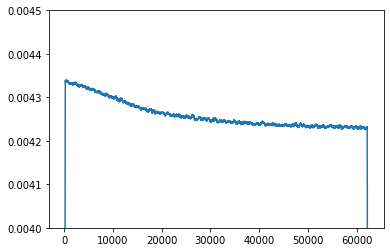

In [260]:
plt.plot(smooth(errs,500))
plt.ylim(0.004,0.0045)

In [76]:
spec_pred.shape

torch.Size([128, 8575])

In [ ]:
torch.save(linear,"linear_poly")
torch.save(z,"z")

In [261]:
        spec = spectra[idxs].to(device)
        #z_poly = expand(z_ones)
        #print(z_poly.shape)
        optimizer.zero_grad()
        #spec_pred = linear(z_poly)
        spec_pred,_ = autoencoder(spec)

(1000, 1200)

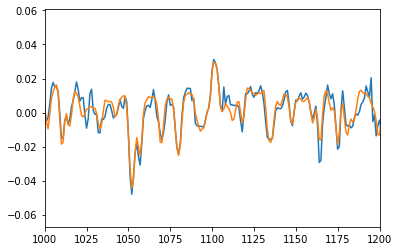

In [262]:
plt.plot(spec[2].cpu().numpy())
plt.plot(spec_pred[2].detach().cpu().numpy())
plt.xlim(1000,1200)

In [81]:
loss(spec[0],spec_pred[0])

tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>)

In [82]:
z[0]

tensor([ 1.0306,  0.8483, -0.4121, -1.2436,  1.0925,  0.8987,  0.2302, -0.2280,
        -0.8666, -1.8465], grad_fn=<SelectBackward>)

In [263]:
_,z = autoencoder(dataset[:][0].to(device))
z=z.detach().cpu().numpy()

# Assessing representation

In [84]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [85]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [264]:
z_vec = vector.Vector(z[:n_data][combined_cut[:n_data]],order=1,interaction_only=False)

In [265]:
w = vector.LinearTransformation(z_vec,y)


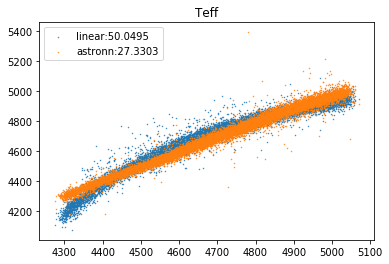

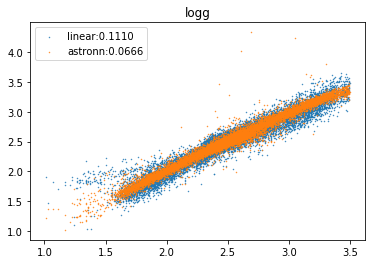

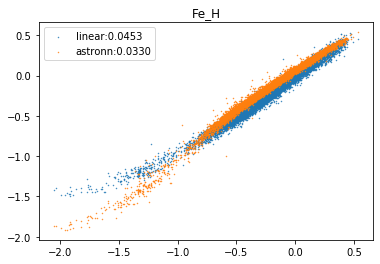

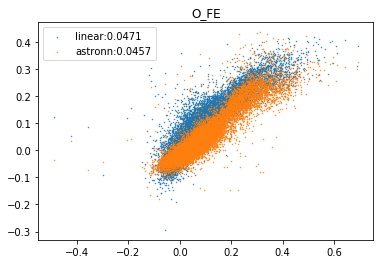

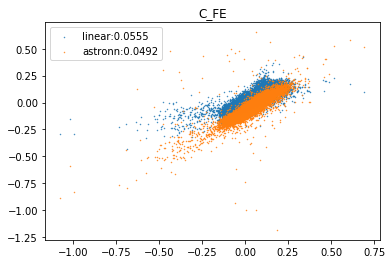

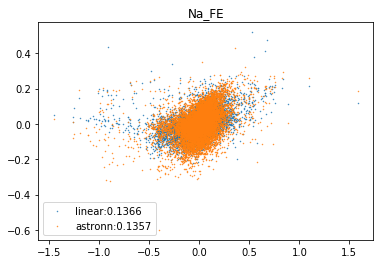

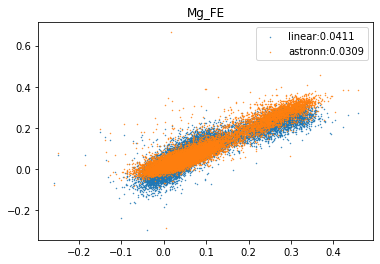

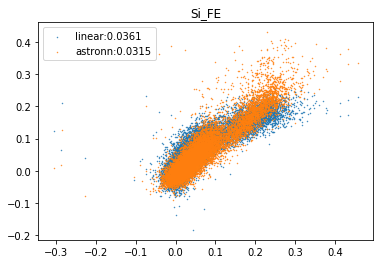

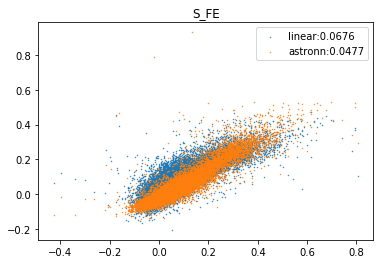

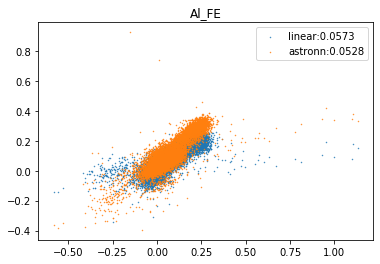

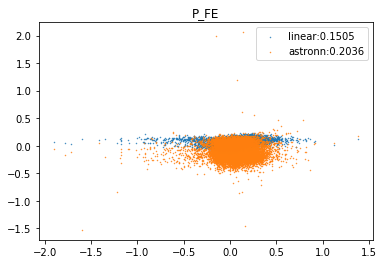

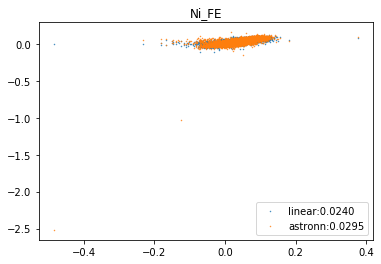

In [166]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

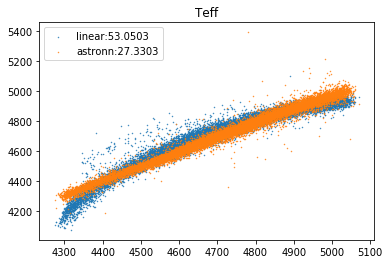

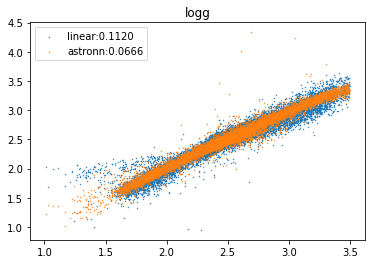

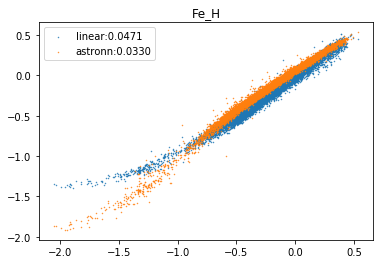

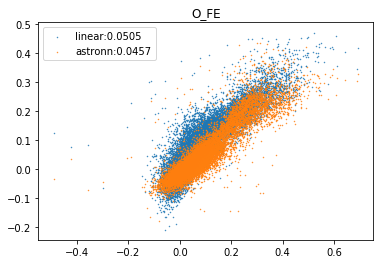

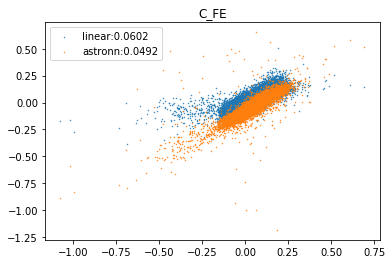

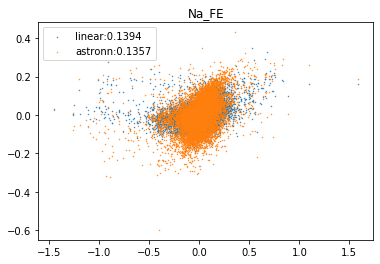

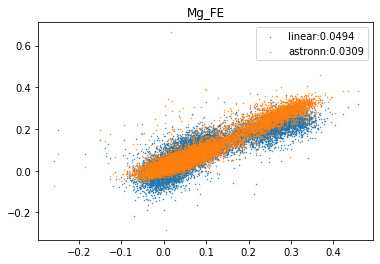

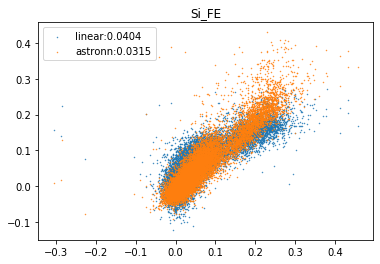

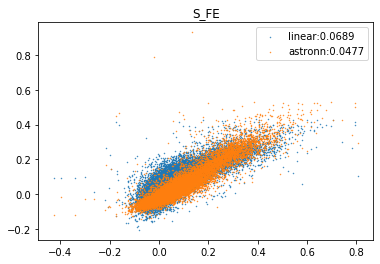

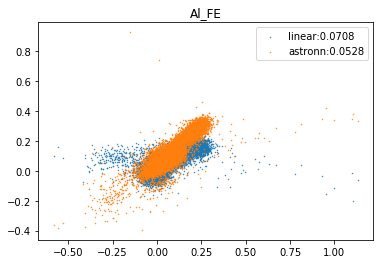

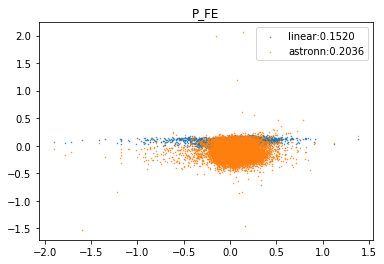

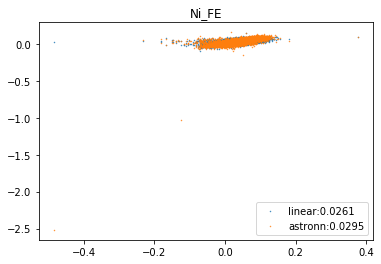

In [97]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

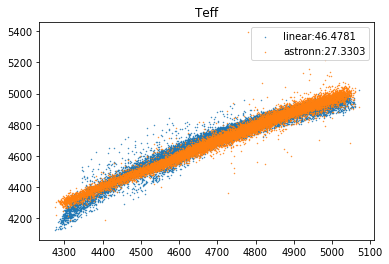

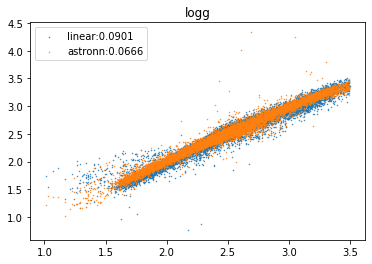

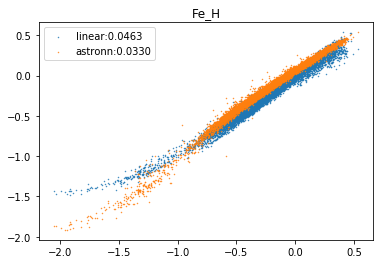

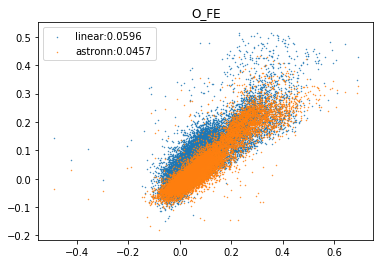

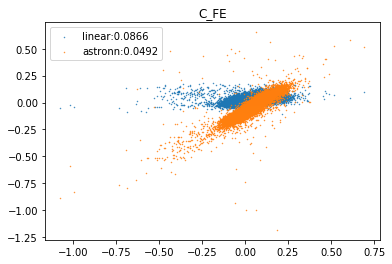

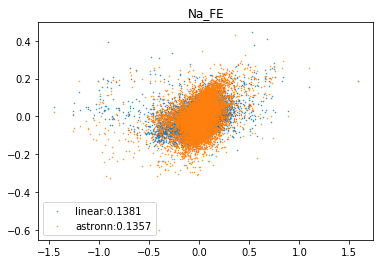

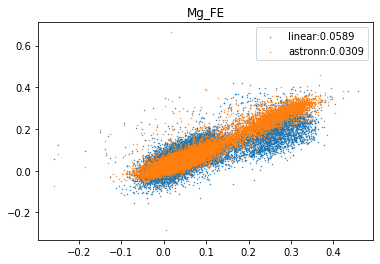

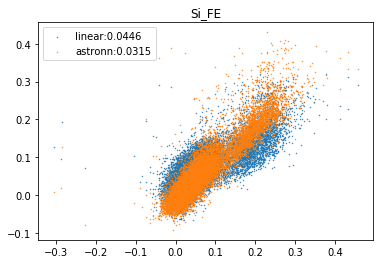

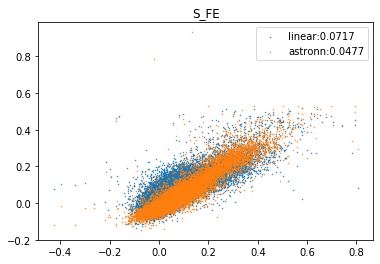

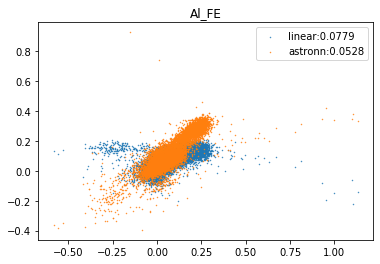

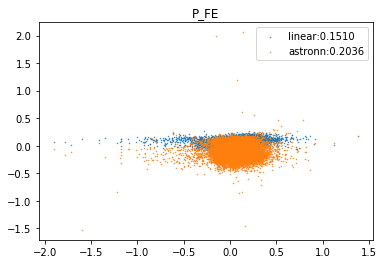

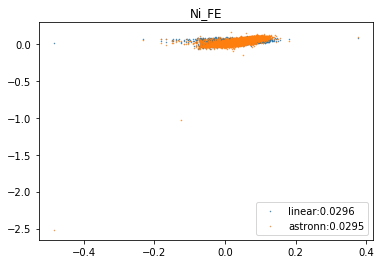

In [266]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

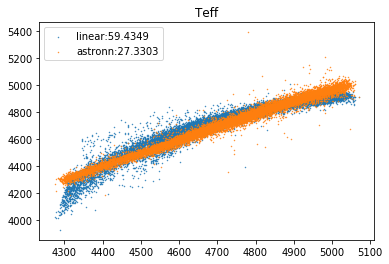

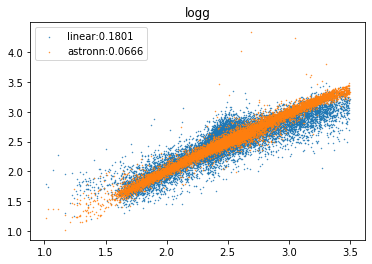

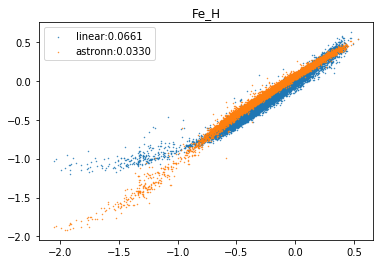

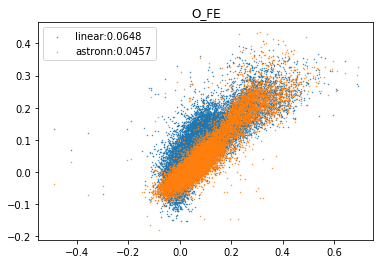

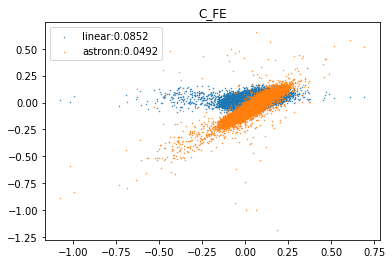

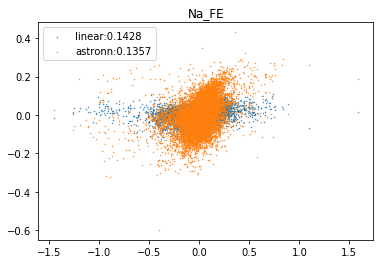

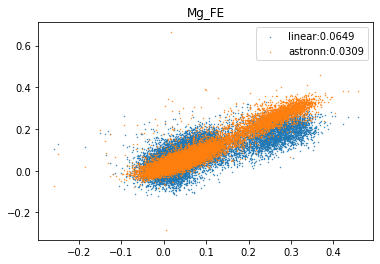

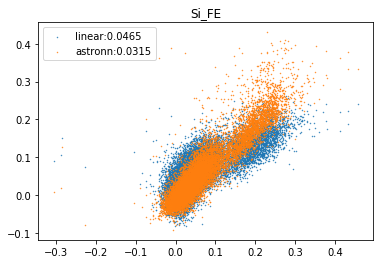

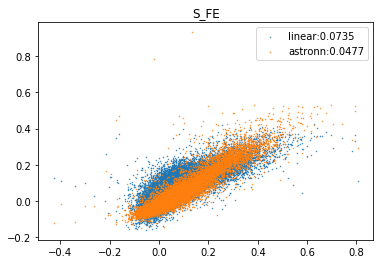

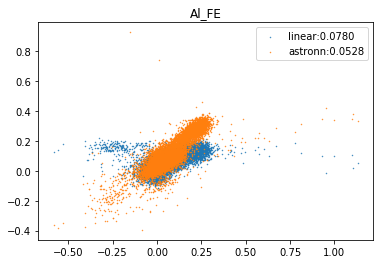

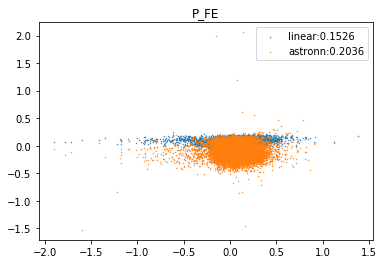

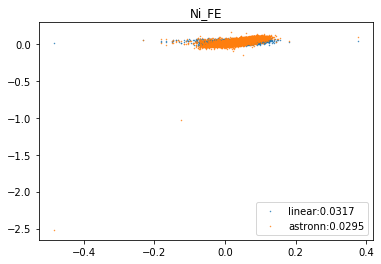

In [35]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    #nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z_vec).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z_vec).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

In [ ]:
indexes = torch.combinations(torch.arange(6), with_replacement=True)


In [ ]:
indexes[:,0]

In [ ]:
z_ones[0][indexes]

In [ ]:
torch.combinations(z_ones[0], with_replacement=True)


In [ ]:
left = torch.index_select(z_ones, 1, indexes[:,0])
right = torch.index_select(z_ones, 1, indexes[:,1])

In [ ]:
left.shape

In [ ]:
ones = torch.ones(len(z),1)
z_ones = torch.cat((z,ones),dim=1)

In [ ]:
z_ones.shape

In [ ]:
z_ones.shape[1]

In [ ]:
def expand(z):
    indexes = torch.combinations(torch.arange(z.shape[1]), with_replacement=True)
    left = torch.index_select(z, 1, indexes[:,0])
    right = torch.index_select(z, 1, indexes[:,1])
    return left*right
    

In [ ]:
expand()

In [ ]:
poly.fit_transform(z[0:4].detach().numpy())

In [ ]:
expand(z_ones[0:4])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=False,include_bias=True)
chain = list(poly._combinations(len(z_ones[0])-1,2,interaction_only=True,include_bias=True))

In [ ]:
len(chain)

In [ ]:
chain

In [ ]:
indexes = torch.combinations(torch.arange(z.shape[1]), with_replacement=False)
len(indexes)

In [ ]:
np.random.randn()

In [102]:
spectr = spectra.numpy() 

In [141]:
z = np.random.randn(n_z,spectr.shape[0])

In [119]:
w = np.random.randn(z.shape[0],spectr.shape[1])

In [142]:
z.shape

(10, 20000)

In [117]:
spectr.shape

(20000, 8575)

In [120]:
w.shape

(10, 8575)

In [121]:
np.dot(z.T,w)=spectr

(20000, 8575)

In [127]:
np.dot(np.linalg.pinv(z.T),spectr).shape

(10, 8575)

In [129]:
np.dot(spectr,np.linalg.pinv(w)).T

array([[ 1.02359940e-04, -1.34540609e-04, -2.24095182e-05, ...,
         6.07719210e-05,  8.65281915e-05,  6.16342173e-05],
       [ 5.14052004e-05, -6.27490764e-05, -3.19105715e-04, ...,
         4.09796213e-04,  2.28588971e-04, -2.89352575e-04],
       [ 2.00150594e-06,  1.13114511e-04,  1.60990010e-04, ...,
        -3.08855020e-04, -4.75865281e-04,  6.27348744e-05],
       ...,
       [ 1.83478956e-04, -7.86505519e-06, -3.73852165e-04, ...,
         8.08080089e-04, -5.33862183e-04, -4.66405007e-04],
       [ 7.80626398e-05, -7.31937540e-05, -1.96755835e-04, ...,
         8.49722551e-04,  2.33222895e-04, -3.30669553e-04],
       [-1.69735562e-04, -4.46935028e-06,  1.99960474e-04, ...,
        -1.62400832e-04,  4.50724314e-04,  2.57763015e-04]])

## Linear Algebra solution

In [180]:
def iterative_regression(spectra,n_z=10):
    z = np.random.randn(n_z,spectra.shape[0])
    for i in range(20):
        w = np.dot(np.linalg.pinv(z.T),spectra)
        z = np.dot(spectr,np.linalg.pinv(w)).T
        print(np.mean(np.dot(z.T,w)-spectra))
    return w,z

In [181]:
w,z = iterative_regression(spectr)

1.3068876214671452e-07
1.1372233364263498e-07
1.2340222552214838e-07
1.239321306106043e-07
1.2162860580580235e-07
1.1951227183411977e-07
1.1818561731146047e-07
1.1745746094067398e-07
1.1707803410917556e-07
1.1688614766505453e-07
1.1679408127518582e-07
1.1675664742698832e-07
1.1675081820396271e-07
1.1676472982524421e-07
1.1679211399997796e-07
1.1682952429202612e-07
1.16874947269814e-07
1.1692709450385701e-07
1.169850322671336e-07
1.1704798222724079e-07


(1000, 1200)

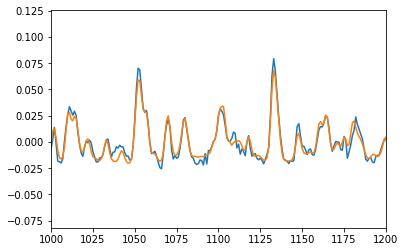

In [182]:
plt.plot(spectr[0])
plt.plot(np.dot(z.T,w)[0])
plt.xlim(1000,1200)

In [183]:
z.shape

(10, 20000)

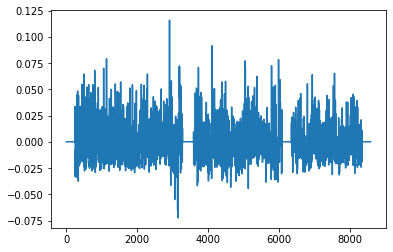

In [184]:
plt.plot(spectr[0])

In [185]:
z.shape

(10, 20000)

In [187]:
z_new = 20
p = np.random.randn(z.shape[0],z_new)

In [194]:
z.shape

(10, 20000)

In [192]:
p.shape

(10, 20)

In [ ]:
def iterative_polynomial_regression(spectra,n_z=50):
    z = np.random.randn(n_z,spectra.shape[0])
    for i in range(10):
        w = np.dot(np.linalg.pinv(z.T),spectra)
        z = np.dot(spectr,np.linalg.pinv(w)).T
        print(np.mean(np.dot(z.T,w)-spectra))
    return w,z

In [ ]:
i